# Spatial Autocorrelation

In the last lecture I have given an overview of Spatial Autocorrelation. In this lecture, we are going to look at a technique that helps to identify whether spatial autocorrelation is present for the variable of interest. 

For this example we are going to use the SVI dataset for the census tracts in Ohio. So let us get the dataset first

In [75]:
import geopandas as gpd
import psycopg2

In [76]:
conn = psycopg2.connect('dbname=nyc user=geospatial password=geospatial2023 host=ghhlibrary')

In [77]:
sviOhio = gpd.read_postgis("select fips,geom,rpl_themes from us_tract_svi where st_abbr='OH' and rpl_themes>=0 and rpl_themes<=10",conn)

In [78]:
sviOhio

,fips,geom,rpl_themes
0,39035101300,"MULTIPOLYGON (((-81.76880 41.47691, -81.76877 ...",0.8187
1,39035117500,"MULTIPOLYGON (((-81.57544 41.55328, -81.57374 ...",0.8029
2,39035118200,"MULTIPOLYGON (((-81.61554 41.52957, -81.60937 ...",0.6814
3,39035119402,"MULTIPOLYGON (((-81.60290 41.48424, -81.59830 ...",0.8137
4,39035124202,"MULTIPOLYGON (((-81.81173 41.43384, -81.80847 ...",0.8128
...,...,...,...
3145,39175938100,"MULTIPOLYGON (((-83.47679 40.94838, -83.45768 ...",0.3652
3146,39175938200,"MULTIPOLYGON (((-83.51588 40.81813, -83.51473 ...",0.1192
3147,39175938300,"MULTIPOLYGON (((-83.32585 40.84699, -83.32180 ...",0.5230
3148,39175938400,"MULTIPOLYGON (((-83.32355 40.81750, -83.32301 ...",0.4961


Now let us create a simple choropleth map 

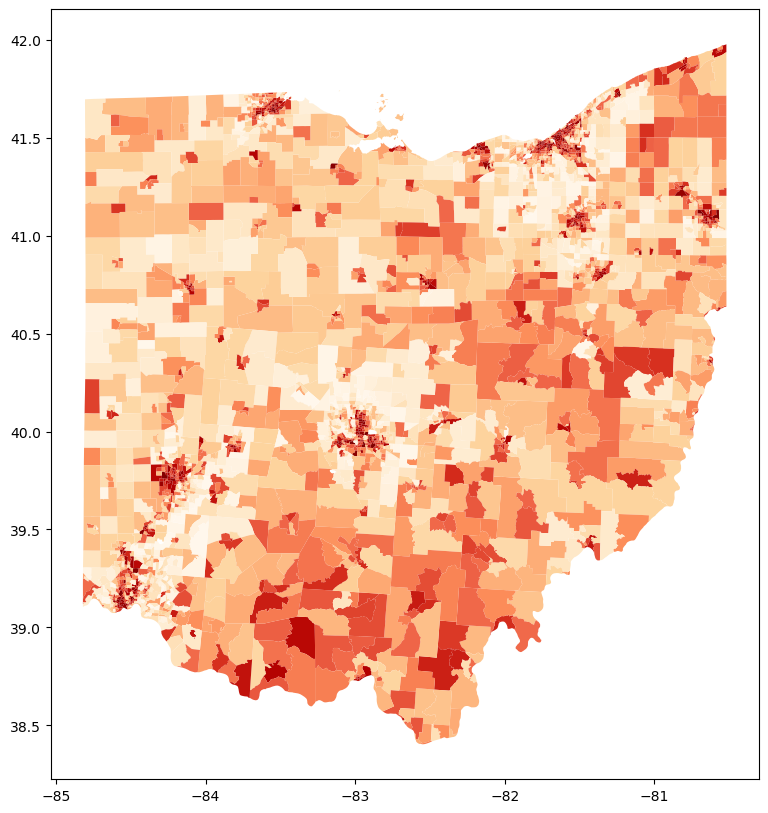

In [79]:
sviOhio.plot(column='rpl_themes', cmap='OrRd',figsize=(10,10));

Just by looking at this map could you identify whether the rpl_themes data is spatially autocorrelated (or are low values closer to other low values or are high values closer to other high values)

## Quantifying Spatial Autocorrelation Globally using Moran's I and Moran's Plot

### Global Measures of Spatial Autocorrelation
Tests for global spatial autocorrelation examine whether the data as a whole exhibit spatial autocorrelation (against a null of spatial randomness) as well as the strength and direction (positive and negative) of any spatial autocorrelation. 
Positive - Similar values close to each other (high-high, low-low)
Negative - Similar values far from each other (high-low)

![Package ](images/positive_negative_spatial_auto.png)


#### Moran Plot

Moran plot is a way of visualizing a spatial dataset to explore the nature and strength of spatial autocorrelation. It is a plot between **variable of interest and its spatial lag**.

##### Spatial Lag
The *spatial lag* is calculated by multiplying the varaible of interest with the corresponding spatial weight. 

$$Y_{sl} = WY\\Y_{sl-i} = \sum_{j}w_{ij}y_j$$
Where *Y<sub>sl</sub>* is the spatial lag for the variable *Y* and *W* is the weight matrix and *Y<sub>sl-i</sub>* is the spatial lag for *Y* at location *i* which is calculated as the sum of spatial lag of all the *Y* values that are with in the neighborhood of *Y<sub>i</sub>*.
If W is standardized, the spatial lag is the *average value of the variable in the neighborhood*.
In order to be able to interpret values as above or below the mean, the variables of interest is usually standardized by subtracting its mean and dividing it by its standard deviation

![Package ](images/spatial_lag.png)

But how do we calculate spatial weights

##### Spatial Weights

Spatial Weights are constructs that **represent geographic relationships between the observational units in a spatially referenced dataset**. Implicitly, spatial weights **connect objects in a geographic table to one another using the spatial relationships between them**. By expressing the notion of geographical proximity or connectedness, spatial weights are the main mechanism through which the spatial relationships in geographical data is brought to bear in the subsequent analysis.

An efficient way of representing spatial weights is through a spatial weights matrix

Spatial weight matrices are structured set of numbers that formalize Geographical Relationships between observations in a dataset.

$$W=\begin{bmatrix} 0 & w_{12} & \dots & w_{1N}\\ w_{21} & \ddots & w_{ij} & \vdots \\ \vdots & w_{ji} & 0 & \vdots \\ w_{1N} & \dots & \dots & 0 \end{bmatrix}$$

Each cell *w*<sub><i>ij</i> </sub> represents the degree of interaction between the observations *i* and *j*. By convention we set the diagonal elements of *W* as zero. We define *j* as a *neighbor* of *i* if *i* has some degree of *connection* with *j*. In terms of the Weight Matrix *W* *j* is a *neighbor* of *i* if *w*<sub><i>ij</i> </sub>>0. And from the defintion for *neighbor* we could define *neighborhood* of *i* as the set of observations in the system with which it has certain connection, or those observations with a weight greater than zero.

There are many ways of creating Weight Matrix *W* which we will explore now.

In [80]:
from pysal.lib import weights
import geopandas as gpd
from splot.esda import moran_scatterplot,lisa_cluster
from pysal.explore import esda
import matplotlib.pyplot as plt

For this example we are going to use County data for Ohio

In [81]:
oh_counties = gpd.read_postgis("select name,geom from us_counties where statefp='39'",conn)
oh_counties

,name,geom
0,Cuyahoga,"MULTIPOLYGON (((-81.97116 41.35306, -81.97086 ..."
1,Defiance,"MULTIPOLYGON (((-84.80405 41.40836, -84.80401 ..."
2,Erie,"MULTIPOLYGON (((-82.73571 41.60336, -82.73392 ..."
3,Paulding,"MULTIPOLYGON (((-84.80378 41.14052, -84.80346 ..."
4,Preble,"MULTIPOLYGON (((-84.81512 39.57295, -84.81512 ..."
...,...,...
83,Auglaize,"MULTIPOLYGON (((-84.45618 40.68486, -84.39678 ..."
84,Franklin,"MULTIPOLYGON (((-83.26088 40.00281, -83.25855 ..."
85,Monroe,"MULTIPOLYGON (((-81.31824 39.73858, -81.31787 ..."
86,Marion,"MULTIPOLYGON (((-83.42025 40.61398, -83.41983 ..."


For calculating weights its always better to have the spatial data in projected coordinate system

In [82]:
oh_counties = oh_counties.to_crs('EPSG:26917')

###### Creating Weights

**Rook Contiguity**

Refers to neighbors sharing a common edge

![Package ](images/Rook.png)

Let us calculate the rook contiguity matrix for our county dataset

In [83]:
rook_counties = weights.Rook.from_dataframe(oh_counties,idVariable="name")

Now if you want to see who all are the neighbors for Cuyahoga county

In [84]:
rook_counties.neighbors['Cuyahoga']

['Medina', 'Geauga', 'Lake', 'Lorain', 'Summit']

As you can see there are five neighbors for Cuyahoga county in rooks contiguity. Now let us just plot this

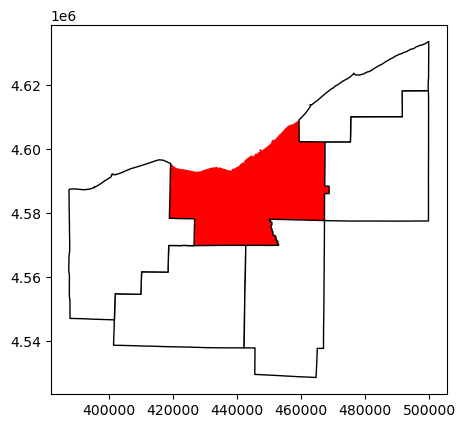

In [85]:
ax = oh_counties[oh_counties.name=='Cuyahoga'].plot(facecolor='red')
oh_counties.loc[oh_counties.name.isin(rook_counties.neighbors['Cuyahoga'])].plot(facecolor='white',ax=ax,edgecolor='black');

Ok now let us look into the next type of contiguity

**Queen Contiguity**

Refers to neighbors sharing a vertex

![Package ](images/Queen.png)

In [86]:
queen_counties = weights.Queen.from_dataframe(oh_counties,idVariable="name")

In [87]:
queen_counties.neighbors['Cuyahoga']

['Medina', 'Geauga', 'Portage', 'Lake', 'Lorain', 'Summit']

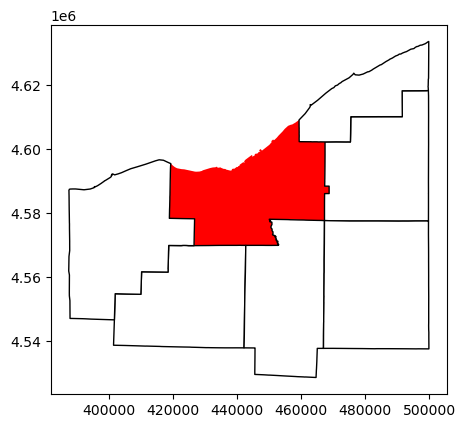

In [88]:
ax = oh_counties[oh_counties.name=='Cuyahoga'].plot(facecolor='red')
oh_counties.loc[oh_counties.name.isin(queen_counties.neighbors['Cuyahoga'])].plot(facecolor='white',ax=ax,edgecolor='black');

Similar to weights based on contiguity, there are also weights based on distance

**k-Nearest Neighbors**

In a *k*-nearest neighbor definition, all units among the *k* nearest neighbors of unit *i* are treated as neighbors of *i*, while the remaining units are treated as non-neighbors.
An example may be that the typical citizen is able to retain the political argument of only five neighbors, at maximum, and is able to retain the political arguments of only five neighbors, and that these neighbors with whom political discussion takes place are the individuals five most spatially proximate neighbors.

In [89]:
kneighbor_counties = weights.KNN.from_dataframe(oh_counties, k=10,ids="name")

In [90]:
kneighbor_counties.neighbors['Cuyahoga']

['Summit',
 'Medina',
 'Geauga',
 'Lorain',
 'Lake',
 'Portage',
 'Wayne',
 'Stark',
 'Trumbull',
 'Erie']

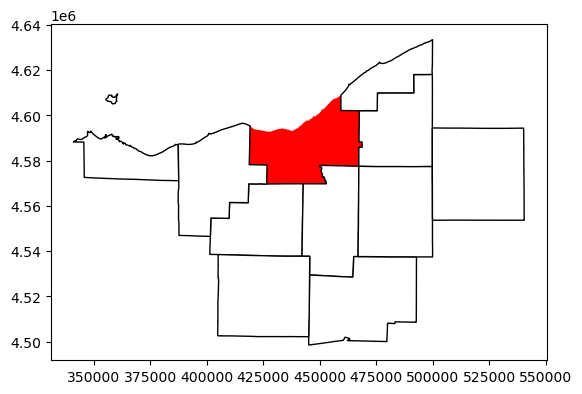

In [91]:
ax = oh_counties[oh_counties.name=='Cuyahoga'].plot(facecolor='red')
oh_counties.loc[oh_counties.name.isin(kneighbor_counties.neighbors['Cuyahoga'])].plot(facecolor='white',ax=ax,edgecolor='black');

**Distance band**

A distance band neighbor defintion will be theoretically supported if the researcher believes that units within a particular distance of unit *i* exhibit *spatial autocorrelation* with unit *i* but that units beyong this critical distance are spatially independent from unit *i*

In [92]:
distbands_100km_counties = weights.DistanceBand.from_dataframe(oh_counties, 100000,ids="name")

In [93]:
distbands_100km_counties.neighbors['Cuyahoga']

['Erie',
 'Mahoning',
 'Medina',
 'Summit',
 'Stark',
 'Geauga',
 'Portage',
 'Wayne',
 'Ashtabula',
 'Huron',
 'Trumbull',
 'Ashland',
 'Lake',
 'Lorain',
 'Holmes']

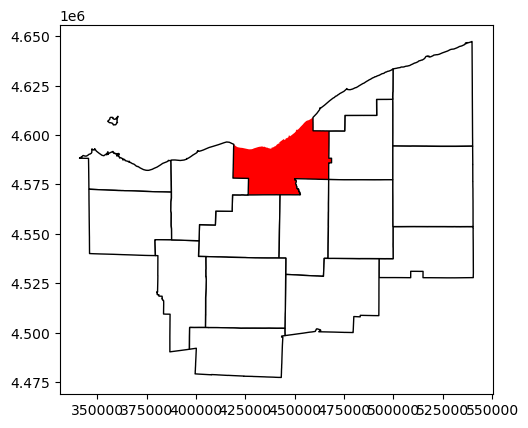

In [94]:
ax = oh_counties[oh_counties.name=='Cuyahoga'].plot(facecolor='red')
oh_counties.loc[oh_counties.name.isin(distbands_100km_counties.neighbors['Cuyahoga'])].plot(facecolor='white',ax=ax,edgecolor='black');

**Standardizing Weight matrices**

For spatial analysis techniques, a spatial weights matrix with raw values may not be suitable as different features might have different number of neighbors. We could standardize the weight matrix using the row sum technique. Row sum is calculated by dividing each spatial weight by the sum of weights of its neighbors. 

For example let use standardize our queen contiguity matrix

In [95]:
print (queen_counties.weights['Cuyahoga'])

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


Apply row sum transformation

In [96]:
queen_counties.transform ='R'

In [97]:
print (queen_counties.weights['Cuyahoga'])

[0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666, 0.16666666666666666]


Now let us get back to Spatial Lag and Standardizing data

![Package](images/standardizedata.png)

Creating a Moran Plot for the SVI data for Ohio

In [98]:
w = weights.Queen.from_dataframe(sviOhio, idVariable='fips')
# Row standardize the matrix
w.transform = 'R'

('WARNING: ', '39123050100', ' is an island (no neighbors)')


In [99]:
morans = esda.Moran(sviOhio['rpl_themes'], w)

Now we can easily get the morans plot by calling the moran_scatterplot function

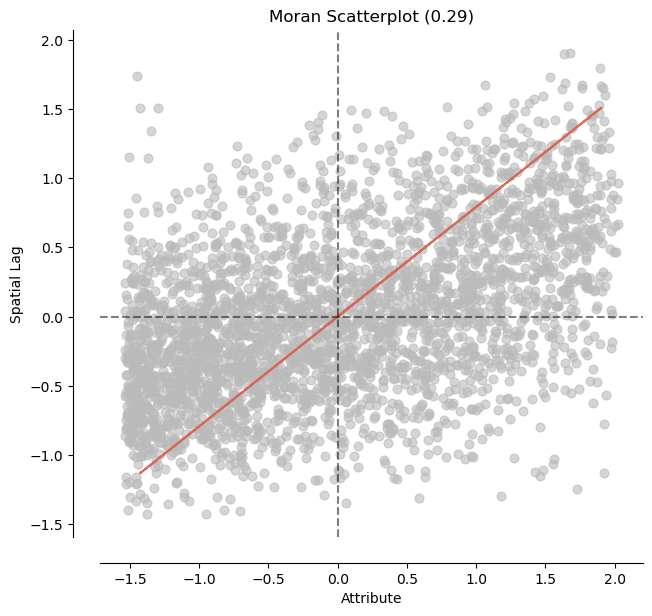

In [101]:
moran_scatterplot(morans);

The four quadrants of this graph represents LH,HH,HL,LL values for spatial attribute and its lag. When there are more number of values in the HH and LL quadrant we tend to say that the data exihibits positive spatial autocorrelation. In this plot we can see that the LL quadrant is packed indicating that there are many low rpl_themes values that are spatially adjacent to each other. The value 0.29 indicates the Moran's I index value which we will dicuss now

**Global Moran's I**


Global Moran's I is a statistical measure that summarizes the spatial autocorrelation. Formally
$$I = \frac{N}{S} \frac{\sum_{i}\sum_{j}w_{ij}(y_i-\overline{y})(y_j-\overline{y})}{\sum_{i}(y_i-\overline{y})^2}$$
where N is the number of observations, S is the sum of weights, *w<sub>ij</sub>* is an element of the spatial weights matrix *W*, *y<sub>i</sub>* and *y<sub>j</sub>* are the values on the random variable at locations *i* and *j*, and <span style="text-decoration:overline">*y*</span> is the mean on *y*. A positive global Moran's I that differs significantly from the expected expected value under null indicates positive spatial autocorrelation - the clustering of similar value among neighboring observations. A negative global Moaran's I that differs significantly from the expected value under the null indicates a negative spatial autocorrelation - the clustering of dissimilar values on the random variable among neighboring observations. 

We can get the value for Moran's I from the esda.Moran object

In [102]:
morans.I

0.28644926660457043

We can also check whether the Moran's I value is statistically significant. 

In [103]:
print (morans.p_sim)

0.001


The *p_sim* value relates to statistical significance: how likely is the pattern we observe in the map and Moran's I captures in its value to be generated by an entirely random process? The *p_sim* value of 0.001 indicates that if we generated a large number of maps with the same values but randomly allocated across space 99.9% of the time the I value calculated will be less than the observed I value of 0.28, indicating statistical significance for I value. 

![Package](images/montecarlo.png)

## Local Measures of Spatial Autocorrealtion

While Moran's I is a __good tool to summarize a dataset into a single value__ that informs about its degree of *clustering*, it is __not appropriate measure to identify__ areas within the map where specific values are located. While Moran's I can tell us values are __clustered overall__, but it will not inform us __*where*__ these clusters are. __*Local*__ measures of autocorrelation helps to identify __*where*__ in the study region there are interesting or anomalous data patterns. Anselin (1995) defintes Local Indicators of Spatial Association (LISA) statistic as any statistic that satisfies two condtions
<ul>
<li> The LISA for each observation measures the extent of significant spatial clustering of similar values around the observation. </li>
<li>The sum of LISAs for all observations is proportional to a corresponding global indicator of spatial association. </li>
</ul>    

Local Moran, which is a LISA statistic, is formally defined as   
$$I_i = \frac{\sum_{j}w_{ij}(y_i-\overline{y})(y_j-\overline{y})}{(y_i-\overline{y})^2}$$   
Through the estimation of LISA statistics, the researcher can identify which observations are consistent with the global pattern of positive or negative spatial autocorrelation and which observations run counter to its global pattern.  The core idea is to identify cases in which the comparison between the value of an observation and the average of its neighbors is either more similar (HH, LL) or dissimilar (HL, LH) than we would expect from pure chance.
Let's use the same dataset to calculate Local Moran

Let us run the same SVI example 

In [104]:
lisa = esda.Moran_Local(sviOhio['rpl_themes'], w)

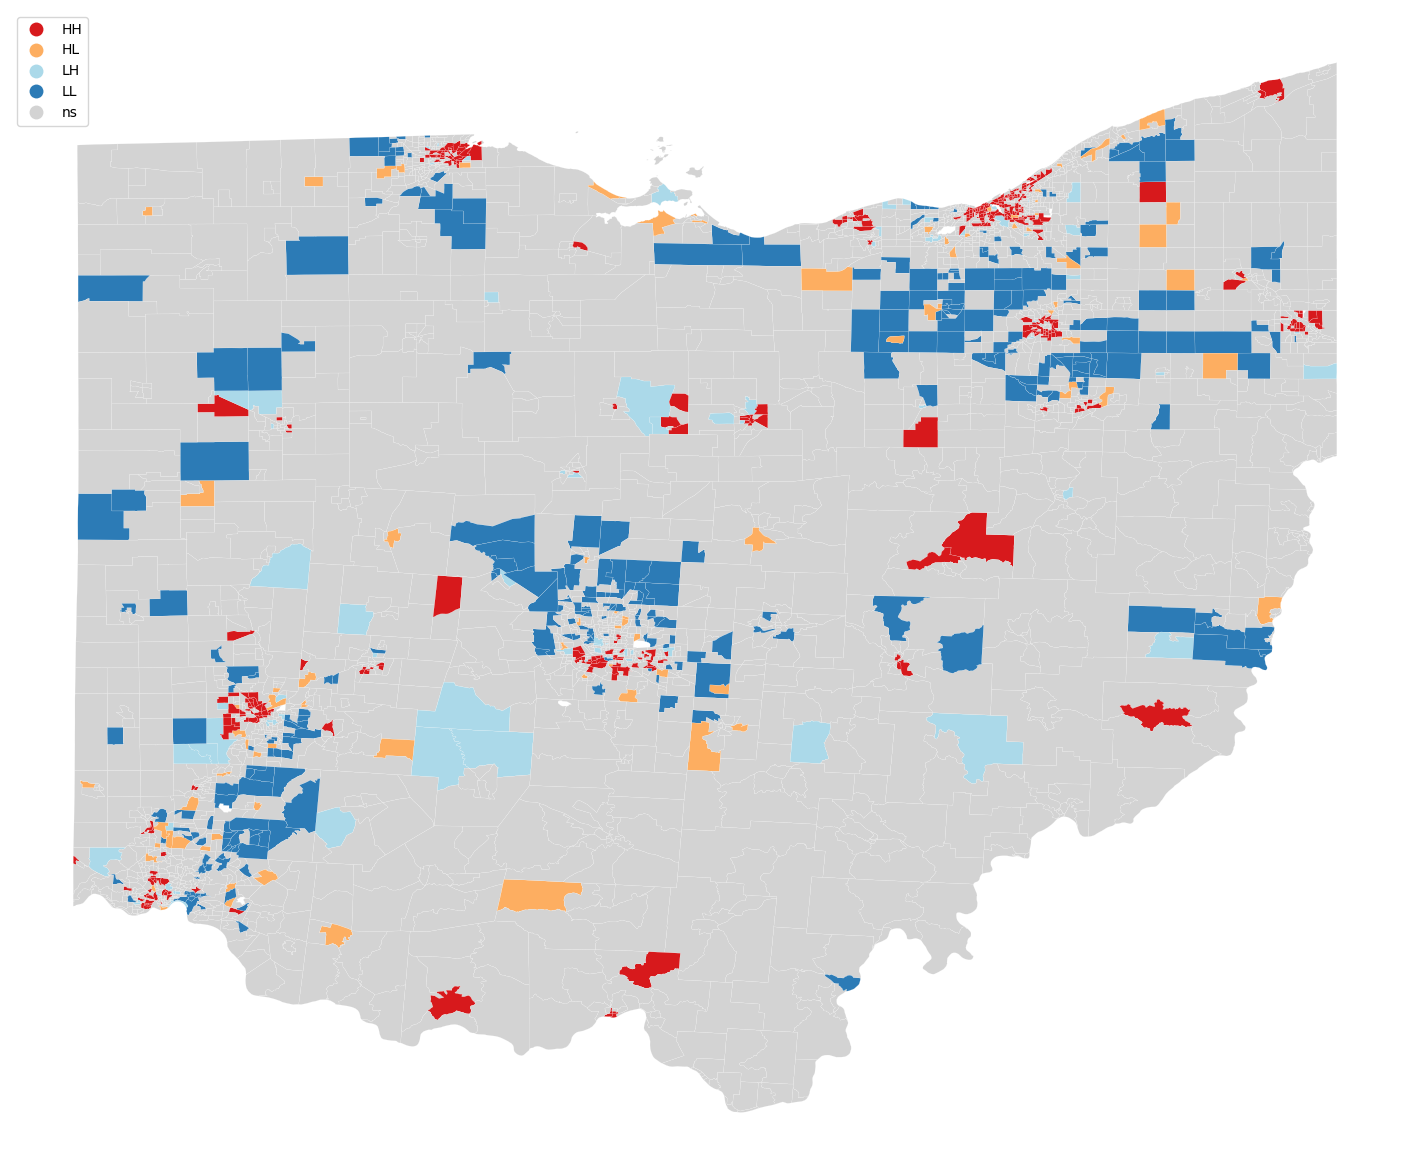

In [105]:
fig, ax = plt.subplots(figsize=(18,15))
lisa_cluster(lisa, sviOhio,ax=ax,legend_kwds={'loc': 'upper left'});